/home/markus/.local/lib/python3.9/site-packages/pandas/core/dtypes/missing.py:531: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val = np.array(val, copy=False)


<AxesSubplot:>

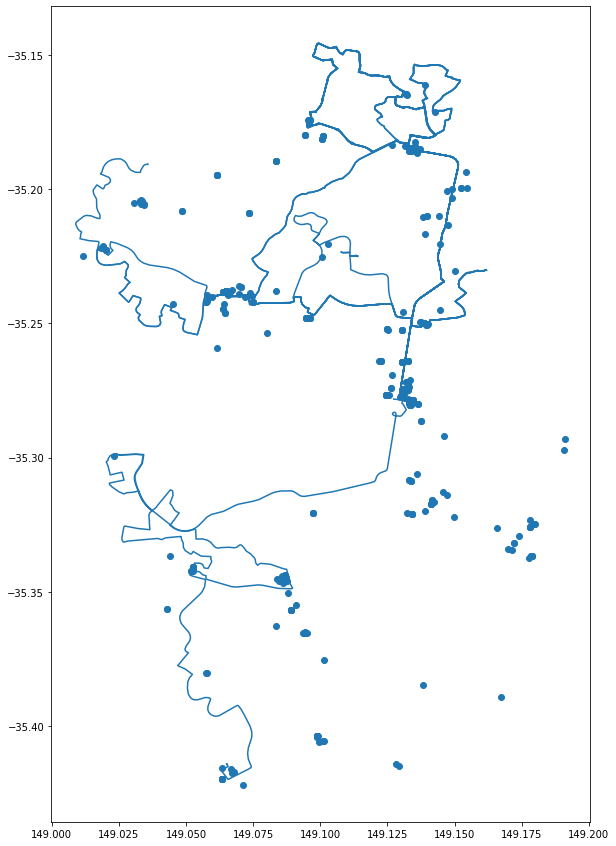

In [92]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box

geoData = gpd.GeoDataFrame()

data = pd.read_csv("results.csv")
data_lr = data[(data["suburb"] == "Public Transport") & (data["location"].apply(lambda x: "Light Rail" in x))]
data_bus = data[(data["suburb"] == "Public Transport") & (data["location"].apply(lambda x: "Bus Route" in x))]
data_geometry = gpd.points_from_xy(data["lng"], data["lat"])

lr_stops = gpd.read_file("lightrailStops.geojson")
lr_line = gpd.read_file("lightrailRoute.geojson")
bus_routes = gpd.read_file("buses.geojson")
bus_routes = bus_routes[bus_routes["rt_tp_txt"] == "Bus"]
bus_routes = bus_routes[["long_name", "route_id", "geometry"]]
bus_routes.columns = ["name", "route", "geometry"]
bus_routes["class"] = "bus"
bus_routes["route"] = bus_routes["route"].apply(lambda x: x[:x.index("-")])

lr_line["class"] = "lr"
lr_line = lr_line[["class", "geometry"]]

routes = data_bus["location"].apply(lambda x: x.split()[2])

for i in data_bus.index:
    geoData.at[i, "contact"] = data_bus.at[i, "contact"]
    geoData.at[i, "class"] = "bus"
    geoData.at[i, "name"] = f"bus route {data_bus.at[i, 'location'].split()[2]}"
    geoData.at[i, "address"] = None
    geoData.at[i, "date"] = data_bus.at[i, "date"]
    try:
        geoData.at[i, "geometry"] = bus_routes[bus_routes["route"] == data_bus.at[i, 'location'].split()[2]].iat[0, 2]
    except:
        geoData.at[i, "geometry"] = None

for i in data_lr.index:
    geoData.at[i, "contact"] = data_lr.at[i, "contact"]
    geoData.at[i, "class"] = "lightrail"
    geoData.at[i, "name"] = "light rail"
    geoData.at[i, "address"] = None
    geoData.at[i, "date"] = data_lr.at[i, "date"]
    geoData.at[i, "geometry"] = lr_line.at[0, "geometry"]

geoData["address"] = geoData["address"].astype("str")
    
for i in data.index:
    if i not in geoData.index:        
        geoData.at[i, "contact"] = data.at[i, "contact"]
        geoData.at[i, "class"] = "location"
        geoData.at[i, "name"] = data.at[i, "location"]
        geoData.at[i, "address"] = data.at[i, 'address'] + ", " + data.at[i, 'suburb']
        geoData.at[i, "date"] = data.at[i, "date"]
        geoData.at[i, "geometry"] = data_geometry[i]

geoData = geoData[geoData["geometry"].notna()]
geoData.simplify(1e-4).to_file("mapData.geojson", driver="GeoJSON")
geoData.simplify(1e-4).plot(figsize=(10, 15))